# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!pip install matplotlib scikit-learn

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
df.head()

Mounted at /content/drive


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [ ]:
from tensorflow.keras.layers import TextVectorization
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

X = df['comment_text']
y = df[df.columns[2:]].values
vectorizer.adapt(X.values)

In [ ]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [ ]:
vectorized_text = vectorizer(X.values)
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
batch_x,batch_y=dataset.as_numpy_iterator().next()

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_generator=train.as_numpy_iterator()
train_generator.next()

(array([[  1104,   1528,     40, ...,      0,      0,      0],
        [    48,    158,   7485, ...,      0,      0,      0],
        [     2,     63,    593, ...,      0,      0,      0],
        ...,
        [    38,     78,     20, ...,      0,      0,      0],
        [  5808,   1114,      4, ...,      0,      0,      0],
        [     1, 179766,   1419, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# 2. Create Sequential Model And Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 962s 137ms/step - loss: 0.0613 - val_loss: 0.0455
Epoch 2/10
6981/6981 [==============================] - 793s 114ms/step - loss: 0.0458 - val_loss: 0.0400
Epoch 3/10
6981/6981 [==============================] - 785s 112ms/step - loss: 0.0404 - val_loss: 0.0352
Epoch 4/10
6981/6981 [==============================] - 835s 120ms/step - loss: 0.0359 - val_loss: 0.0313
Epoch 5/10
6981/6981 [==============================] - 796s 114ms/step - loss: 0.0326 - val_loss: 0.0283
Epoch 6/10
6981/6981 [==============================] - 791s 113ms/step - loss: 0.0298 - val_loss: 0.0261
Epoch 7/10
6981/6981 [==============================] - 781s 112ms/step - loss: 0.0262 - val_loss: 0.0227
Epoch 8/10
6981/6981 [==============================] - 790s 113ms/step - loss: 0.0239 - val_loss: 0.0204
Epoch 9/10
6981/6981 [==============================] - 803s 115ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 10/10
6981/6981 [=======================

In [ ]:
model.save('toxicity10epoch.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Figure size 800x500 with 0 Axes>

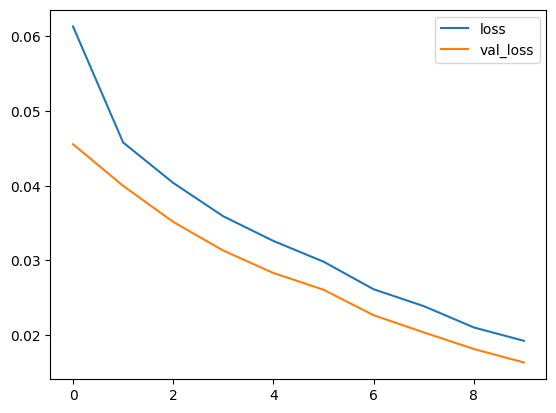

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 60ms/step


In [ ]:
precision_value = pre.result().numpy()
recall_value = re.result().numpy()
accuracy_value = acc.result().numpy()

# Creating a DataFrame
df = pd.DataFrame({'Metric': ['Precision', 'Recall', 'Accuracy'],
                   'Value': [precision_value, recall_value, accuracy_value]})

# Displaying the DataFrame
print(df)

      Metric     Value
0  Precision  0.924234
1     Recall  0.911580
2   Accuracy  0.538616


# 4. Make Predictions

In [ ]:
# Assume your model expects an input shape like (batch_size, sequence_length)
# Ensure that the sequence_length matches the parameters you used for the TextVectorization layer
sequence_length = 1800

# Example input text
input_text = ['You freaking suck! I am going to hit you.']

# Vectorize the input text
input_text_vectorized = vectorizer(input_text)

# Pad the sequence to match the expected sequence length
input_text_padded = tf.keras.preprocessing.sequence.pad_sequences(
    input_text_vectorized.numpy(), maxlen=sequence_length
)

# Make predictions using the model
res = model.predict(input_text_padded)

# Convert predictions to binary (0 or 1) based on a threshold (0.5 in this case)
binary_prediction = (res > 0.5).astype(int)

# Print the result
print("Predicted Toxicity:", binary_prediction)


1/1 [==============================] - 1s 815ms/step
Predicted Toxicity: [[1 0 1 1 1 0]]
